In [23]:
%matplotlib inline
import numpy as np
from sklearn import metrics
import scipy
import matplotlib.pyplot as plt
import os
import pickle
import pprint
pp = pprint.PrettyPrinter(indent=4)

In [2]:
# 500 max word length, LSTM only architecture, 20 of the top level classes, 100 epochs
# predictionPath = 'results/epochPreds_500ML_LSTM_20Class.npy'
# avgLossPath = 'results/epochAvgLoss_500ML_LSTM_20Class.npy'
# lossSavepath = 'src/plotting/resultPlotting/trainingLoss_500ML_LSTM_20Class.png'

# predictionPath = 'results/epochPreds_500ML_LSTM_20Class_paddingFix.npy'
# avgLossPath = 'results/epochAvgLoss_500ML_LSTM_20Class_paddingFix.npy'
# avgLossValidPath = 'results/epochAvgLossValid_500ML_LSTM_20Class_paddingFix.npy'
# lossSavepath = 'src/plotting/resultPlotting/trainingLoss_500ML_LSTM_20Class_paddingFix.png'
# precRecSavePath = 'src/plotting/resultPlotting/precRec_500ML_LSTM_20Class_paddingFix.png'
# rankMetricsPath = 'src/plotting/resultPlotting/rankMetricsPerf_500ML_LSTM_20Class_paddingFix.png'
# coverageErrorPath = 'src/plotting/resultPlotting/coverageError_500ML_LSTM_20Class_paddingFix.png'

# truePath = 'results/yDev.npy'

# resultPath = 'results/LSTM_300embed_500ML_50Hidden_baseline/'
# resultPath = 'results/LSTM_300embed_500ML_100Hidden/'
resultPath = 'results/testingModelScript/'

In [3]:
epochAvgLoss = np.loadtxt(os.path.join(resultPath, 'epochAvgLoss.gz'))
epochAvgLossValid = np.loadtxt(os.path.join(resultPath, 'epochAvgLossValid.gz'))
yDev = np.loadtxt(os.path.join(resultPath, 'yDev.gz'))
epochPredictions = np.loadtxt(os.path.join(resultPath, 'epochPreds.gz'))
predsRealShape = np.loadtxt(os.path.join(resultPath, 'epochPredsShape.gz')).astype(int)
# epochPredictions = epochPredictions.reshape((epochAvgLoss.shape[0], yDev.shape[0], yDev.shape[1]))
epochPredictions = epochPredictions.reshape(predsRealShape)

In [4]:
np.loadtxt(os.path.join(resultPath, 'epochPredsShape.gz')).astype(int)

array([   13, 13181,    19])

In [5]:
print(yDev.shape)

(13181, 19)


In [6]:
epochAvgLoss.shape[0]

13

In [7]:
print(epochPredictions.shape)
print(epochAvgLoss.shape)
print(yDev.shape)

(13, 13181, 19)
(13,)
(13181, 19)


In [24]:
with open(os.path.join(resultPath, 'hyperParamDict.pickle'), 'rb') as handle:
    hyperParamDict = pickle.load(handle)
pp.pprint(hyperParamDict)

{   'EMBED_SIZE': 300,
    'batchSize': 256,
    'inputKeepProb': 1,
    'learningRate': 0.001,
    'maxGradNorm': 5,
    'maxNoteLength': 500,
    'n_hidden': 200,
    'numLayers': 1,
    'outputKeepProb': 0.5,
    'trainingEpochsMax': 100}


In [8]:
predsRaw = scipy.special.expit(epochPredictions)# this is sigmoid function applied element wise
preds = predsRaw
preds[preds >= 0.5] = 1
preds[preds < 0.5] = 0
bestEpoch = np.argmin(epochAvgLossValid)
nEpochs = epochPredictions.shape[0]

In [10]:
epochAvgLossValid

array([ 0.49101809,  0.48363891,  0.47843388,  0.47640011,  0.46368563,
        0.45741147,  0.45116395,  0.44243091,  0.43614459,  0.43046659,
        0.43058917,  0.43346304,  0.43774065])

In [11]:
bestEpoch = np.argmin(epochAvgLossValid)
# kinda hacky but I assume it would never be exactly zero.
print('best model at epoch %d with a validation loss of %.5f'%(bestEpoch, epochAvgLossValid[bestEpoch]))

best model at epoch 9 with a validation loss of 0.43047


In [12]:
precOverEpoch = np.zeros(preds.shape[0])
recOverEpoch = np.zeros(preds.shape[0])
f1OverEpoch = np.zeros(preds.shape[0])
coverErrOverEpoch = np.zeros(preds.shape[0])
rankLossOverEpoch = np.zeros(preds.shape[0])
lrapOverEpoch = np.zeros(preds.shape[0])
for epoch in range(preds.shape[0]):
    prec = metrics.precision_score(y_pred = preds[epoch,:,:], y_true= yDev, average = 'samples')
    rec = metrics.recall_score(y_pred = preds[epoch,:,:], y_true= yDev, average = 'samples')
    f1 = metrics.f1_score(y_pred = preds[epoch,:,:], y_true= yDev, average = 'samples')
    coverErr = metrics.coverage_error(yDev, predsRaw[epoch, :,:])
    rankLoss = metrics.label_ranking_loss(yDev, predsRaw[epoch,:,:])
    lrap = metrics.label_ranking_average_precision_score(yDev, predsRaw[epoch,:,:])
    coverErrOverEpoch[epoch] = coverErr
    rankLossOverEpoch[epoch] = rankLoss
    lrapOverEpoch[epoch] = lrap
    precOverEpoch[epoch] = prec
    recOverEpoch[epoch] = rec
    f1OverEpoch[epoch] = f1

/home/oliverbdw4/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/oliverbdw4/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [13]:
prec = metrics.precision_score(y_pred = preds[bestEpoch,:,:], y_true= yDev, average = 'samples')
rec = metrics.recall_score(y_pred = preds[bestEpoch,:,:], y_true= yDev, average = 'samples')
f1 = metrics.f1_score(y_pred = preds[bestEpoch,:,:], y_true= yDev, average = 'samples')
print('Precsion score averaged over samples %3f'%(prec))
print('Recall score averaged over samples %3f'%(rec))
print('F1 score averaged over samples %3f'%(f1))
print('Rank loss %f \n'%rankLossOverEpoch[bestEpoch])
with open(os.path.join(resultPath, 'bestPerformance.txt'), 'w') as performanceFile:
    performanceFile.write('Precsion score averaged over samples %f \n'%(prec))
    performanceFile.write('Recall score averaged over samples %f \n'%(rec))
    performanceFile.write('F1 score averaged over samples %f \n'%(f1))
    performanceFile.write('Rank loss %f \n'%rankLossOverEpoch[bestEpoch])

Precsion score averaged over samples 0.750854
Recall score averaged over samples 0.637568
F1 score averaged over samples 0.655366
Rank loss 0.458675 



/home/oliverbdw4/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/oliverbdw4/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [37]:
prec = metrics.precision_score(y_pred = preds[bestEpoch,:,:], y_true= yDev, average = 'samples')
rec = metrics.recall_score(y_pred = preds[bestEpoch,:,:], y_true= yDev, average = 'samples')
f1 = metrics.f1_score(y_pred = preds[bestEpoch,:,:], y_true= yDev, average = 'samples')
print('Precsion score averaged over samples %3f'%(prec))
print('Recall score averaged over samples %3f'%(rec))
print('F1 score averaged over samples %3f'%(f1))
print('Rank loss %f \n'%rankLossOverEpoch[bestEpoch])
with open(os.path.join(resultPath, 'bestPerformance.txt'), 'w') as performanceFile:
    performanceFile.write('Precsion score averaged over samples %f \n'%(prec))
    performanceFile.write('Recall score averaged over samples %f \n'%(rec))
    performanceFile.write('F1 score averaged over samples %f \n'%(f1))
    performanceFile.write('Rank loss %f \n'%rankLossOverEpoch[bestEpoch])

Precsion score averaged over samples 0.732420
Recall score averaged over samples 0.541020
F1 score averaged over samples 0.594404
Rank loss 0.528595 



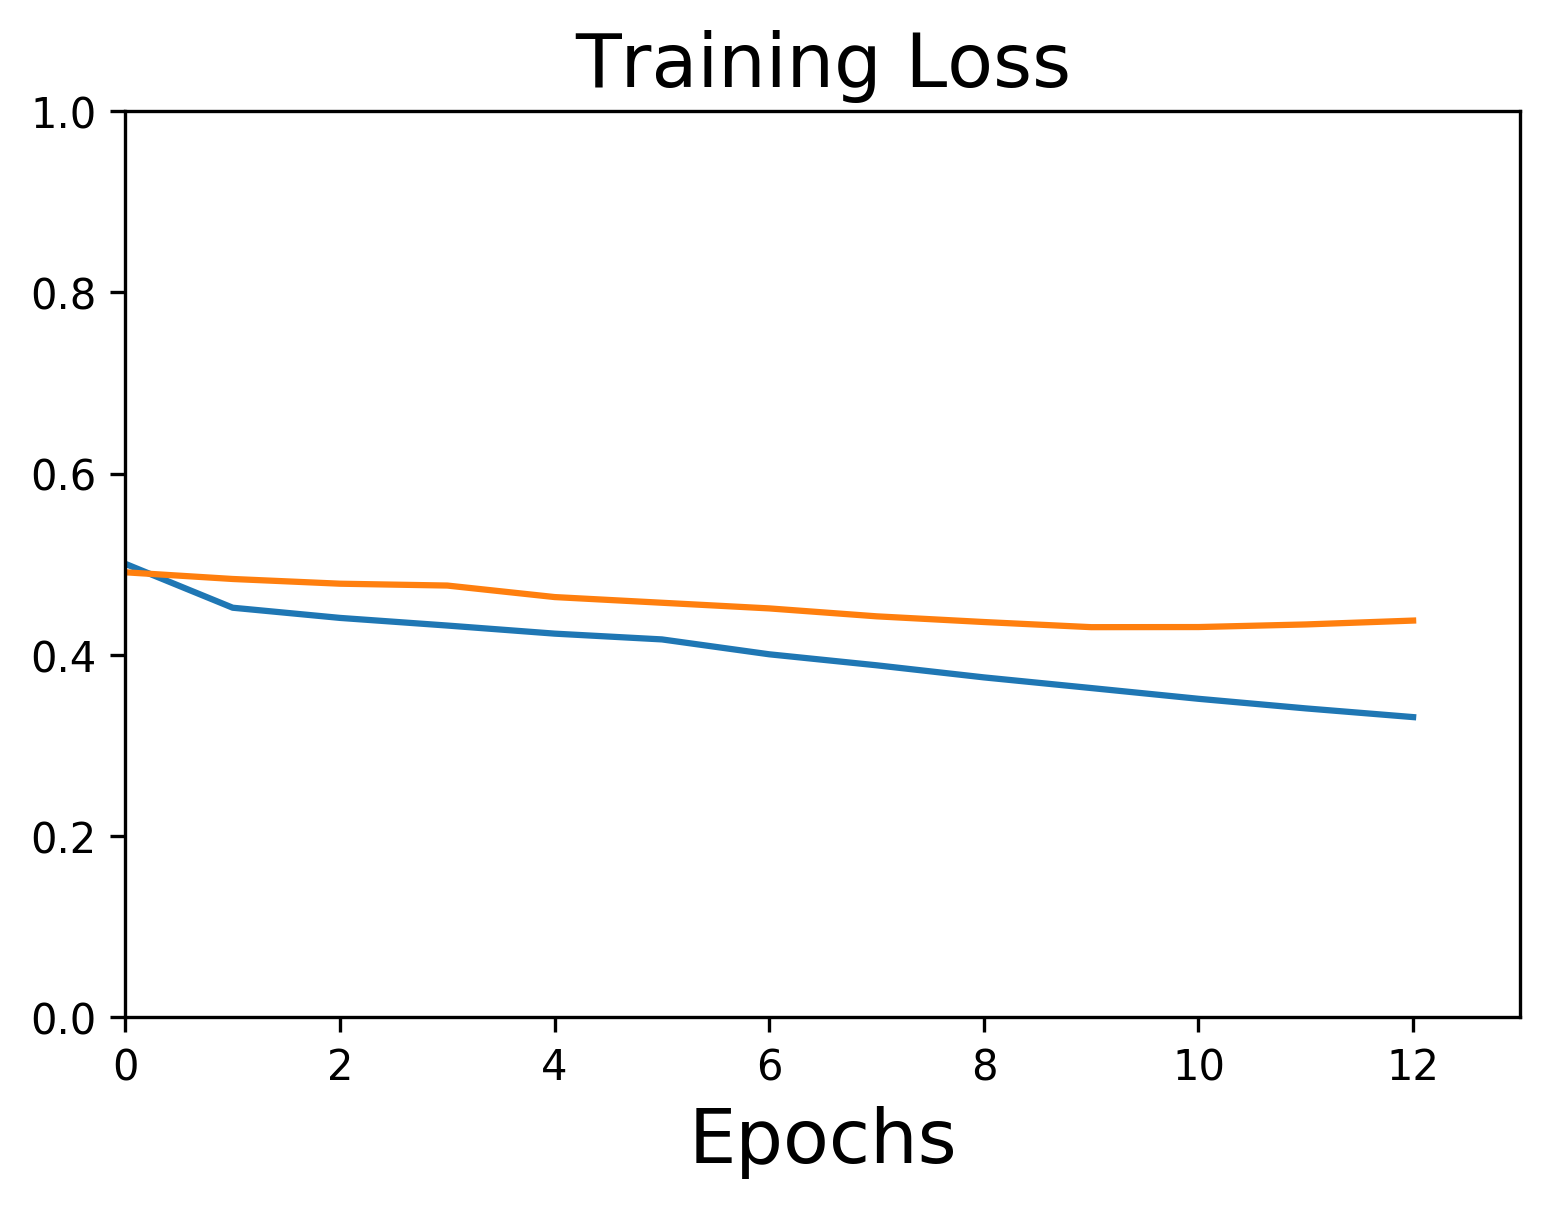

In [14]:
fig = plt.figure(dpi = 300)
x = range(preds.shape[0])
plt.plot(x, epochAvgLoss)
plt.plot(x, epochAvgLossValid)
plt.axis([0, epochPredictions.shape[0], 0, 1.0])
plt.title('Training Loss', fontsize = 18)
plt.xlabel('Epochs', fontsize = 18)
# plt.show()
fig.savefig(os.path.join(resultPath, 'loss.png'))

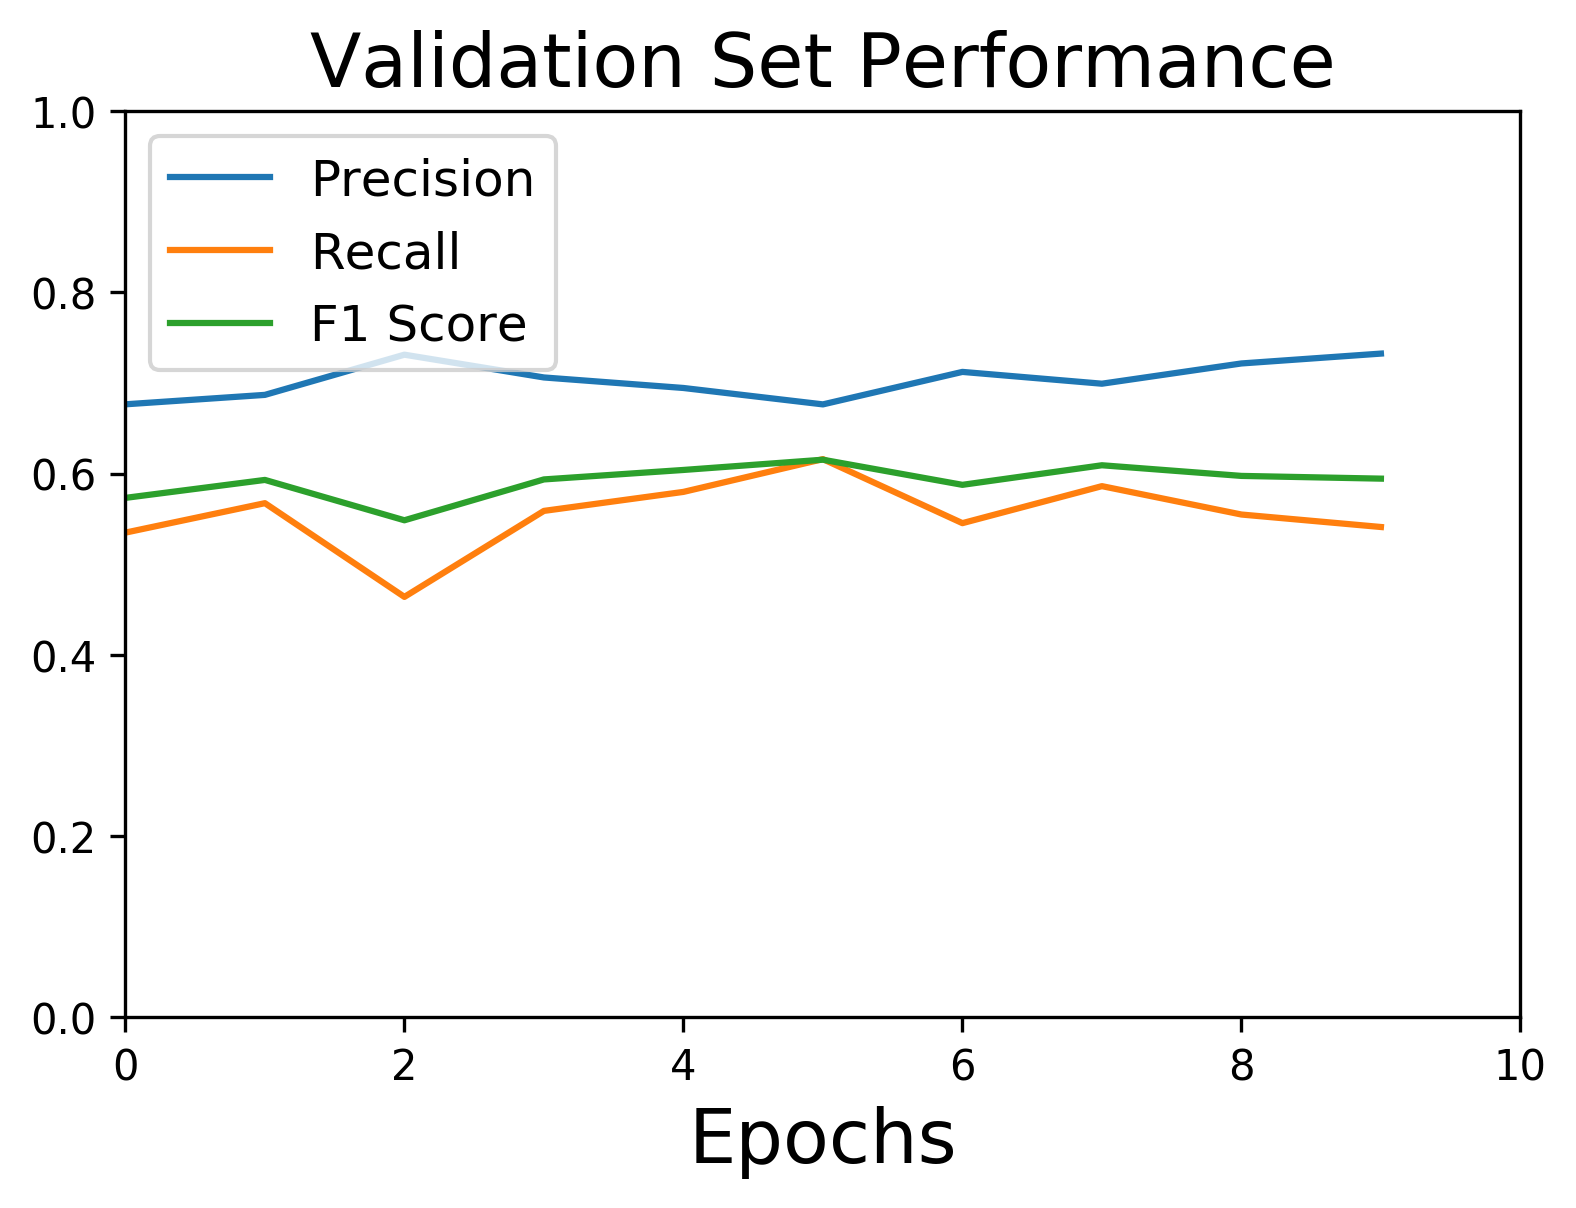

In [31]:
nEpochs = preds.shape[0]
fig = plt.figure(dpi = 300)
x = range(preds.shape[0])
plt.plot(x, precOverEpoch)
plt.plot(x, recOverEpoch)
plt.plot(x, f1OverEpoch)
plt.axis([0, nEpochs, 0, 1.0])

plt.legend(['Precision', 'Recall', 'F1 Score'], loc='upper left', fontsize = 12)
plt.title('Validation Set Performance', fontsize = 18)
plt.xlabel('Epochs', fontsize = 18)
# plt.show()
fig.savefig(os.path.join(resultPath, 'precRecF1.png'))
# fig.savefig('src/plotting/resultPlotting/performance.png')

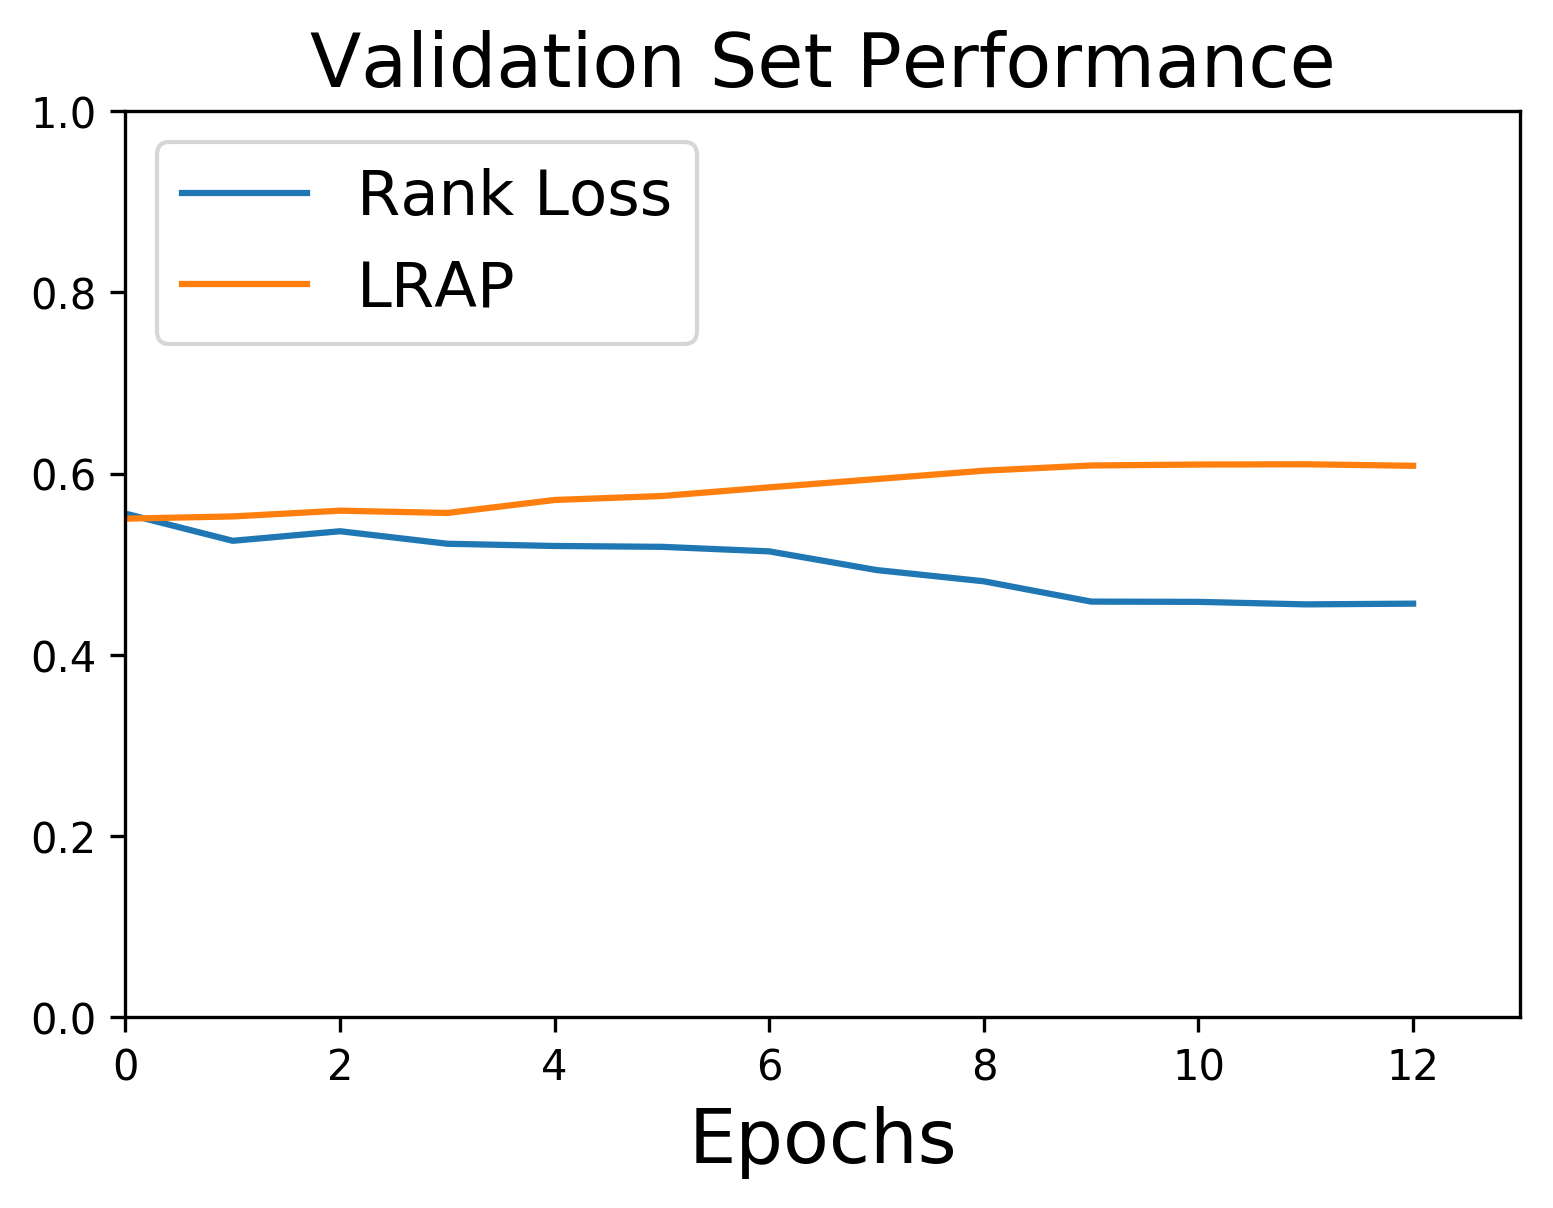

In [15]:
fig = plt.figure(dpi = 300)
x = range(preds.shape[0])
plt.plot(x, rankLossOverEpoch)
plt.plot(x, lrapOverEpoch)
plt.axis([0, nEpochs, 0, 1.0])

plt.legend(['Rank Loss', 'LRAP'], loc='upper left', fontsize = 15)
plt.title('Validation Set Performance', fontsize = 18)
plt.xlabel('Epochs', fontsize = 18)
# plt.show()
fig.savefig(os.path.join(resultPath, 'rankLoss.png'))

The mean number of codes in the devSet is 6.698


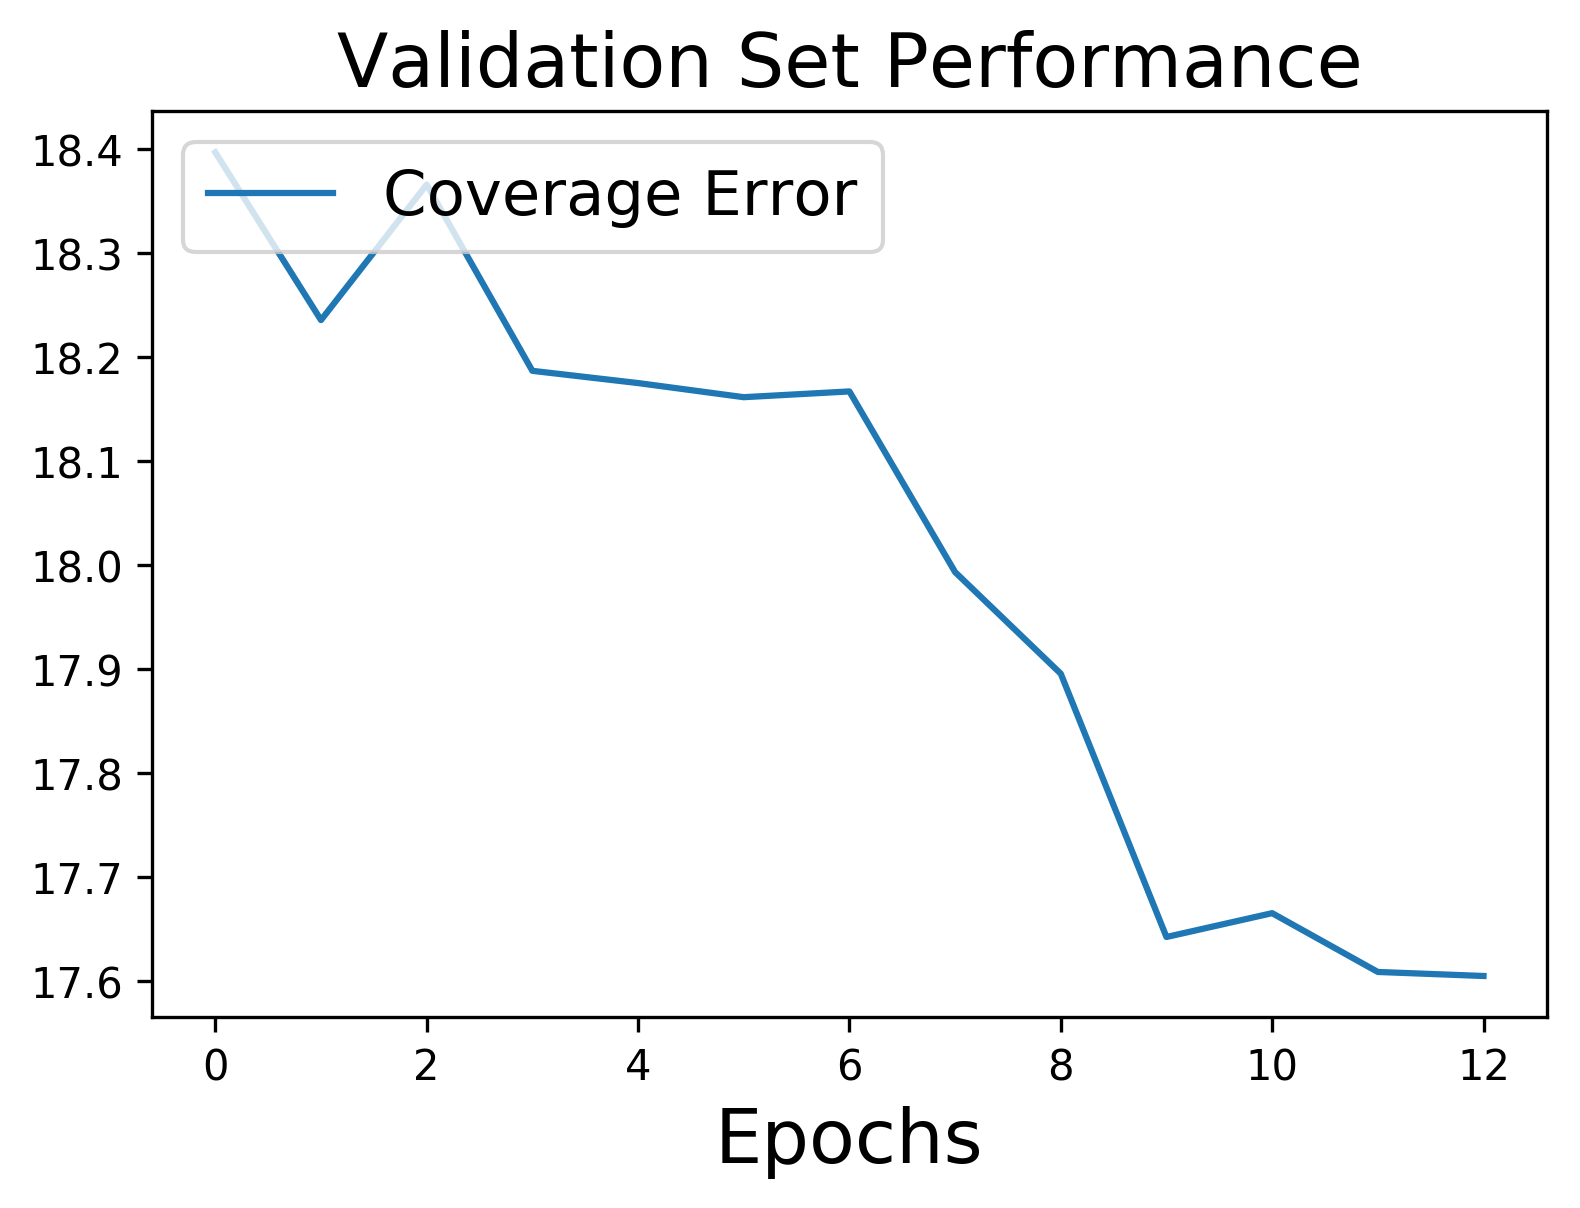

In [16]:
meanNumberOfCodes = np.sum(yDev, axis = 1)
meanNumberOfCodes = np.mean(meanNumberOfCodes)
print('The mean number of codes in the devSet is %.3f'%meanNumberOfCodes)
fig = plt.figure(dpi = 300)
x = range(preds.shape[0])
plt.plot(x, coverErrOverEpoch)

plt.legend(['Coverage Error'], loc='upper left', fontsize = 15)
plt.title('Validation Set Performance', fontsize = 18)
plt.xlabel('Epochs', fontsize = 18)
# plt.show()
fig.savefig(os.path.join(resultPath, 'coverage.png'))

## Confusion Matrices
Thus in binary classification, the count of true negatives is $C_{0,0}$, false negatives is $C_{1,0}$, true positives is $C_{1,1}$ and false positives is $C_{0,1}$.


As of right now this code isn't real

In [ ]:
temp = preds[99,:,:]
yTruth = yTruth
confusionMatrix = np.zeros(shape = (temp.shape[1], temp.shape[1]))
# print(confusionMatrix)-
currTruth = np.zeros(temp.shape[1])
currPred = np.zeros(temp.shape[1])
for colIdx in range(temp.shape[1]):
    currTruth = yTruth[:, colIdx]
    currPred = temp[:, colIdx]
    confMat = metrics.confusion_matrix(y_true = currTruth, y_pred = currPred)
    print(confMat)
    print('***************************')

In [ ]:
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix


for i in range(preds.shape[0]):
    cm = confusion_matrix(y_target=yTruth[:,i], 
                          y_predicted=preds[99,:,i])
    plot_confusion_matrix(conf_mat=cm)
    plt.show()
